## Hello fellow Kagglers,

This notebook demonstrates the training process on a TPU in Tensorflow.

Thanks to the use of a [TPU (Tensor Processing Unit)](https://cloud.google.com/tpu) training takes about an hour.

The TFREcord dataset contains cropped images sized 1344x768, created in [this notebook](https://www.kaggle.com/code/markwijkhuizen/rsna-preprocessing-tfrecords-640x512-dataset).

20% of the data is used for validation, which reaches ~0.20 pF1 with the best threshold.

**Things that did not work for me:**

* [SigmoidFocalCrossEntropy](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy)
* Increasing model size to for example EfficientNetV2S

**Things that did work for me:**

* Class weights: give minority class weight of 10
* Training on TPU instead of GPU: larger batch size (16x2->16x8) giving larger probability of having positive sample in batch
* Cropping Images
* Using Cropped Image Ratio

I enjoy this competition and will update this notebook frequently, stay tuned!

**V2**

* Cropped images in 1344x768 resolution
* EfficientNetV2T
* Added augmentations
* Single image modal instead of both CC and MLO views as input

**V4**

* Switch to modern ConvNextV2 models [paper: ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders](https://arxiv.org/pdf/2301.00808.pdf)
* Reduced learning rate 1e-4xN_REPLICAS -> 5e-6xN_REPLICAS
* Adam -> AdamW optimizer with 0.01 Weight Decay ratio
* Removed Warmup Epochs

**V5**

This will be the final update of my notebooks for this competitions, which should achieve a LB score in the low 0.50s. I will continue participating in this competition, however, I will not share my progress anymore.

* Mainly updated preprocessing strategy, see [Preprocessing Notebook](https://www.kaggle.com/code/markwijkhuizen/rsna-cropped-tfrecords-768x1344-dataset)

[RSNA Cropped TFRecords 768x1344 Dataset](https://www.kaggle.com/code/markwijkhuizen/rsna-cropped-tfrecords-768x1344-dataset)

[Inference Notebook](https://www.kaggle.com/markwijkhuizen/rsna-efficientnetv2-inference-tensorflow)

Good luck to all of you in the last month of this excisting competition!

In [1]:
# Install ConvNextV2 Models From Keras CV Attention Models Pip Package
!pip install -qq /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from keras_cv_attention_models import convnext

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version: 2.4.1
Python Version: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


# Save Versions

In [3]:
now = datetime.datetime.now().strftime("%d-%b-%Y %H-%M-%S")
np.save(now, np.array([now]))

# Mixed Precision Policy

In [4]:
# float32 or mixed_float16 (mixed precision: compute float16, variable float32)
# TPU is fast enough and has enough memory to use float32
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Compute dtype: float32
Variable dtype: float32


# Matplotlib Config

In [5]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

Running on TPU  grpc://10.0.0.2:8470
N_REPLICAS: 8, IS_TPU: True


In [7]:
# For TPU's the dataset needs to be stored in Google Cloud
# Retrieve the Google Cloud location of the dataset
GCS_DS_PATH = KaggleDatasets().get_gcs_path('rsna-tfrecords-xxxxx')

In [8]:
SEED = 42
DEBUG = False

# Image dimensions
IMG_HEIGHT = 1152
IMG_WIDTH = 1152
N_CHANNELS = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
N_SAMPLES_TFRECORDS = 548

# Peak Learning Rate
LR_MAX = 5e-6 * N_REPLICAS
WD_RATIO = 0.01

N_WARMUP_EPOCHS = 0
N_EPOCHS = 2 if DEBUG else 12

# Batch size
BATCH_SIZE = 8 * N_REPLICAS

# Is Interactive Flag and COrresponding Verbosity Method
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}')

BATCH_SIZE: 64


# Seed

In [9]:
# Seed all random number generators
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

# Train

In [10]:
# Train DataFrame
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

display(train.head())
display(train.info())

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

None

# Utility Functions

In [11]:
# short Tensorflow randin integer function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

# chance of 1 in k
def one_in(k):
    return 0 == tf_rand_int(0, k)

# Dataset

In [12]:
# Function to benchmark the dataset
def benchmark_dataset(dataset, num_epochs=3, n_steps_per_epoch=10, bs=BATCH_SIZE):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for idx, (inputs, labels) in enumerate(dataset.take(n_steps_per_epoch + 1)):
            if idx == 0:
                epoch_start = time.perf_counter()
            elif idx == 1 and epoch_num == 0:
                image = inputs['image']
                print(f'image shape: {image.shape}, labels shape: {labels.shape}, image dtype: {image.dtype}, labels dtype: {labels.dtype}')
            else:
                pass
        
        epoch_t = time.perf_counter() - epoch_start
        mean_step_t = round(epoch_t / n_steps_per_epoch * 1000, 1)
        n_imgs_per_s = int(1 / (mean_step_t / 1000) * bs)
        print(f'epoch {epoch_num} took: {round(epoch_t, 2)} sec, mean step duration: {mean_step_t}ms, images/s: {n_imgs_per_s}')

In [13]:
# Plots a batch of images
def show_batch(dataset, n_rows=16, n_cols=4):
    inputs, targets = next(iter(dataset))
    images = inputs['image'].numpy().squeeze()
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4, n_rows*7))
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            # Image
            img = images[idx]
            axes[r, c].imshow(img)
            # Target
            target = targets[idx]
            axes[r, c].set_title(f'target: {target}', fontsize=16, pad=5)
        
    plt.show()

In [14]:
# Decodes the TFRecords
def decode_image(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
    })
    
    # Decode PNG Image
    image = tf.io.decode_jpeg(features['image'], channels=N_CHANNELS)
    # Explicit reshape needed for TPU
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])

    target = features['target']
    
    return { 'image': image }, target

In [15]:
def augment_image(X, y):
    image = X['image']
    
    # Random Brightness
    image = tf.image.random_brightness(image, 0.10)
    
    # Random Contrast
    image = tf.image.random_contrast(image, 0.90, 1.10)
    
    # Random JPEG Quality
    image = tf.image.random_jpeg_quality(image, 75, 100)
    
    # Random crop image with maximum of 10%
    ratio = tf.random.uniform([], 0.75, 1.00)
    img_height_crop = tf.cast(ratio * IMG_HEIGHT, tf.int32)
    img_width_crop = tf.cast(ratio * IMG_WIDTH, tf.int32)
    # Random offset for crop
    img_height_offset = tf_rand_int(0, IMG_HEIGHT - img_height_crop)
    img_width_offset = 0
    # Crop And Resize
    image = tf.slice(image, [img_height_offset, img_width_offset, 0], [img_height_crop, img_width_crop, N_CHANNELS])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    # Clip pixel values in range [0,255] to prevent underflow/overflow
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, tf.uint8)
    
    return { 'image': image }, y

In [16]:
# Undersample majority class (0/negative) by randomly dropping them
def undersample_majority(X, y):
    # Filter 2/3 of negative samples to upsample positive samples by a factor 3
    # Filter 4/5 of negative samples to upsample positive samples by a factor 5
    # Filter 1/2 of negative samples to upsample positive samples by a factor 2
    # Filter 1/3 of negative samples to upsample positive samples by a factor 1.5
    # Filter 1/4 of negative samples to upsample positive samples by a factor 1.33


    return y == 1 or tf.random.uniform([]) > 0.5

In [17]:
# TFRecord file paths
TFRECORDS_FILE_PATHS = sorted(tf.io.gfile.glob(f'{GCS_DS_PATH}/*.tfrecords'))

if DEBUG:
    TFRECORDS_FILE_PATHS = TFRECORDS_FILE_PATHS[:10]
print(f'Found {len(TFRECORDS_FILE_PATHS)} TFRecords')

Found 100 TFRecords


In [18]:
def get_dataset(tfrecords, bs=BATCH_SIZE, val=False, debug=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    # Initialize dataset with TFRecords
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO, compression_type='GZIP')
    
    # Decode mapping
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    if not val:
        dataset = dataset.filter(undersample_majority)
        dataset = dataset.map(augment_image, num_parallel_calls=AUTO)
        dataset = dataset.with_options(ignore_order)
        if not debug:
            dataset = dataset.shuffle(1024)
        dataset = dataset.repeat()        

    dataset = dataset.batch(bs, drop_remainder=not val)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [19]:
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
# if splittype == 'kfold':
# kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
# enumsplit = []
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind, val_ind])

# enumsplit = []
# kfold = StratifiedKFold(5, shuffle=True, random_state=42)
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(range(len(data)),data.purchased)):
#     enumsplit.append([trn_ind, val_ind])
        
        
enumsplit = []
# kfoldgroup = KFold(n_splits = 5)
skf = KFold(n_splits=5,shuffle=True,random_state=SEED)
TFRECORDS_FILE_PATHS_array = np.array(TFRECORDS_FILE_PATHS)
for fold, (trn_ind, val_ind) in enumerate(skf.split(range(len(TFRECORDS_FILE_PATHS)))):
    enumsplit.append([list(TFRECORDS_FILE_PATHS_array[trn_ind]), list(TFRECORDS_FILE_PATHS_array[val_ind])])

In [20]:
for fold, (TFRECORDS_TRAIN, TFRECORDS_VAL) in enumerate(enumsplit):    
    print(f'# TFRECORDS_TRAIN: {len(TFRECORDS_TRAIN)}, # TFRECORDS_VAL: {len(TFRECORDS_VAL)}')


# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20


In [21]:
# from sklearn.model_selection import KFold

# skf = KFold(n_splits=5,shuffle=True,random_state=SEED)


# for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    
# for X_train,X_test in kf.split(X):
#     print(X_train,X_test)
#     # Train Test Split
#     TFRECORDS_TRAIN, TFRECORDS_VAL = train_test_split(TFRECORDS_FILE_PATHS, train_size=0.80, random_state=SEED, shuffle=True)
#     print(f'# TFRECORDS_TRAIN: {len(TFRECORDS_TRAIN)}, # TFRECORDS_VAL: {len(TFRECORDS_VAL)}')

In [22]:
# Get Train/Validation datasets
train_dataset = get_dataset(TFRECORDS_TRAIN, val=False, debug=False)
val_dataset = get_dataset(TFRECORDS_VAL, val=True, debug=False)

TRAIN_STEPS_PER_EPOCH = len(TFRECORDS_TRAIN) * N_SAMPLES_TFRECORDS // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(TFRECORDS_VAL) * N_SAMPLES_TFRECORDS // BATCH_SIZE
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}, VAL_STEPS_PER_EPOCH: {VAL_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171


In [23]:
# Sanity check, image and label statistics
X_batch, y_batch = next(iter(get_dataset(TFRECORDS_TRAIN, val=False)))
image = X_batch['image'].numpy()
print(f'image shape: {image.shape}, y_batch shape: {y_batch.shape}')
print(f'image dtype: {image.dtype}, y_batch dtype: {y_batch.dtype}')
print(f'image min: {image.min():.2f}, max: {image.max():.2f}')

image shape: (64, 1152, 1152, 1), y_batch shape: (64,)
image dtype: uint8, y_batch dtype: <dtype: 'int64'>
image min: 0.00, max: 255.00


In [24]:
# Benchmark Dataset
benchmark_dataset(get_dataset(TFRECORDS_TRAIN, val=False))

image shape: (64, 1152, 1152, 1), labels shape: (64,), image dtype: <dtype: 'uint8'>, labels dtype: <dtype: 'int64'>
epoch 0 took: 1.35 sec, mean step duration: 134.9ms, images/s: 474
epoch 1 took: 1.39 sec, mean step duration: 139.1ms, images/s: 460
epoch 2 took: 1.08 sec, mean step duration: 108.1ms, images/s: 592


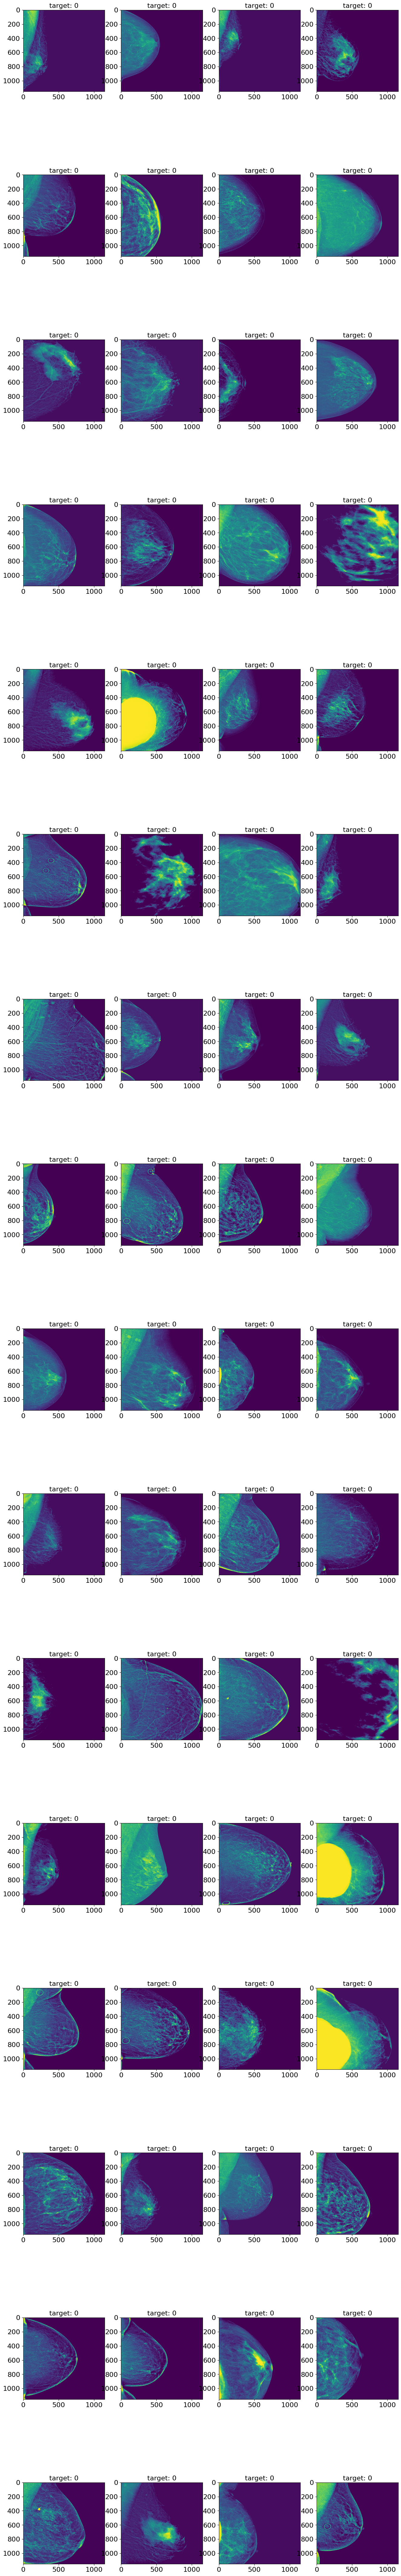

In [25]:
# Show what we will be training on
show_batch(get_dataset(TFRECORDS_TRAIN, bs=64, val=False))

# Class Imbalance

In [26]:
# Label Distribution Train With Undersampled Majority Class
N = 128
train_labels = []
for _, labels in tqdm(get_dataset(TFRECORDS_TRAIN, val=False).take(N), total=N):
    train_labels += labels.numpy().tolist()
    
display(pd.concat((
        pd.Series(train_labels).value_counts(normalize=True).to_frame('Train Label Ratio'),
        pd.Series(train_labels).value_counts().to_frame('Train Label Count'),
    ), axis=1)
)

  0%|          | 0/128 [00:00<?, ?it/s]

Train Label Ratio  Train Label Count
0           0.960083               7865
1           0.039917                327

In [27]:
# Label Distribution Validation (Unchanged)
val_labels = []
for _, labels in tqdm(get_dataset(TFRECORDS_VAL, val=True), total=VAL_STEPS_PER_EPOCH):
    val_labels += labels.numpy().tolist()
    
display(pd.concat((
        pd.Series(val_labels).value_counts(normalize=True).to_frame('Val Label Ratio'),
        pd.Series(val_labels).value_counts().to_frame('Val Label Count'),
    ), axis=1)
)

  0%|          | 0/171 [00:00<?, ?it/s]

Val Label Ratio  Val Label Count
0         0.976147            10681
1         0.023853              261

# pF1 Metric

inspiration: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Train]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train#Metric)

The source implementation is however buggy, it is a moving average which does not reset each epoch. The implementation below does reset each epoch.

In [28]:
# Tensorflow custom metric is just a conventional class object
class pF1(tf.keras.metrics.Metric):
    # Initialize properties
    def __init__(self, name='pF1', **kwargs):
        super(pF1, self).__init__(name=name, **kwargs)
        self.tc = self.add_weight(name='tc', initializer='zeros')
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    # Update state called on each batch with true and predicted labels
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tc.assign_add(tf.cast(tf.reduce_sum(y_true), tf.float32))
        self.tp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 1])), tf.float32))
        self.fp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 0])), tf.float32))

    # Result function is called to obtain result which is printed in progress bar
    def result(self):
        if self.tc == 0 or (self.tp + self.fp) == 0:
            return 0.0
        else:
            precision = self.tp / (self.tp + self.fp)
            recall = self.tp / (self.tc)
            return 2 * (precision * recall) / (precision + recall)

    # Reset state is called after each epoch to start fresh each epoch
    def reset_state(self):
        self.tc.assign(0)
        self.tp.assign(0)
        self.fp.assign(0)

# Model

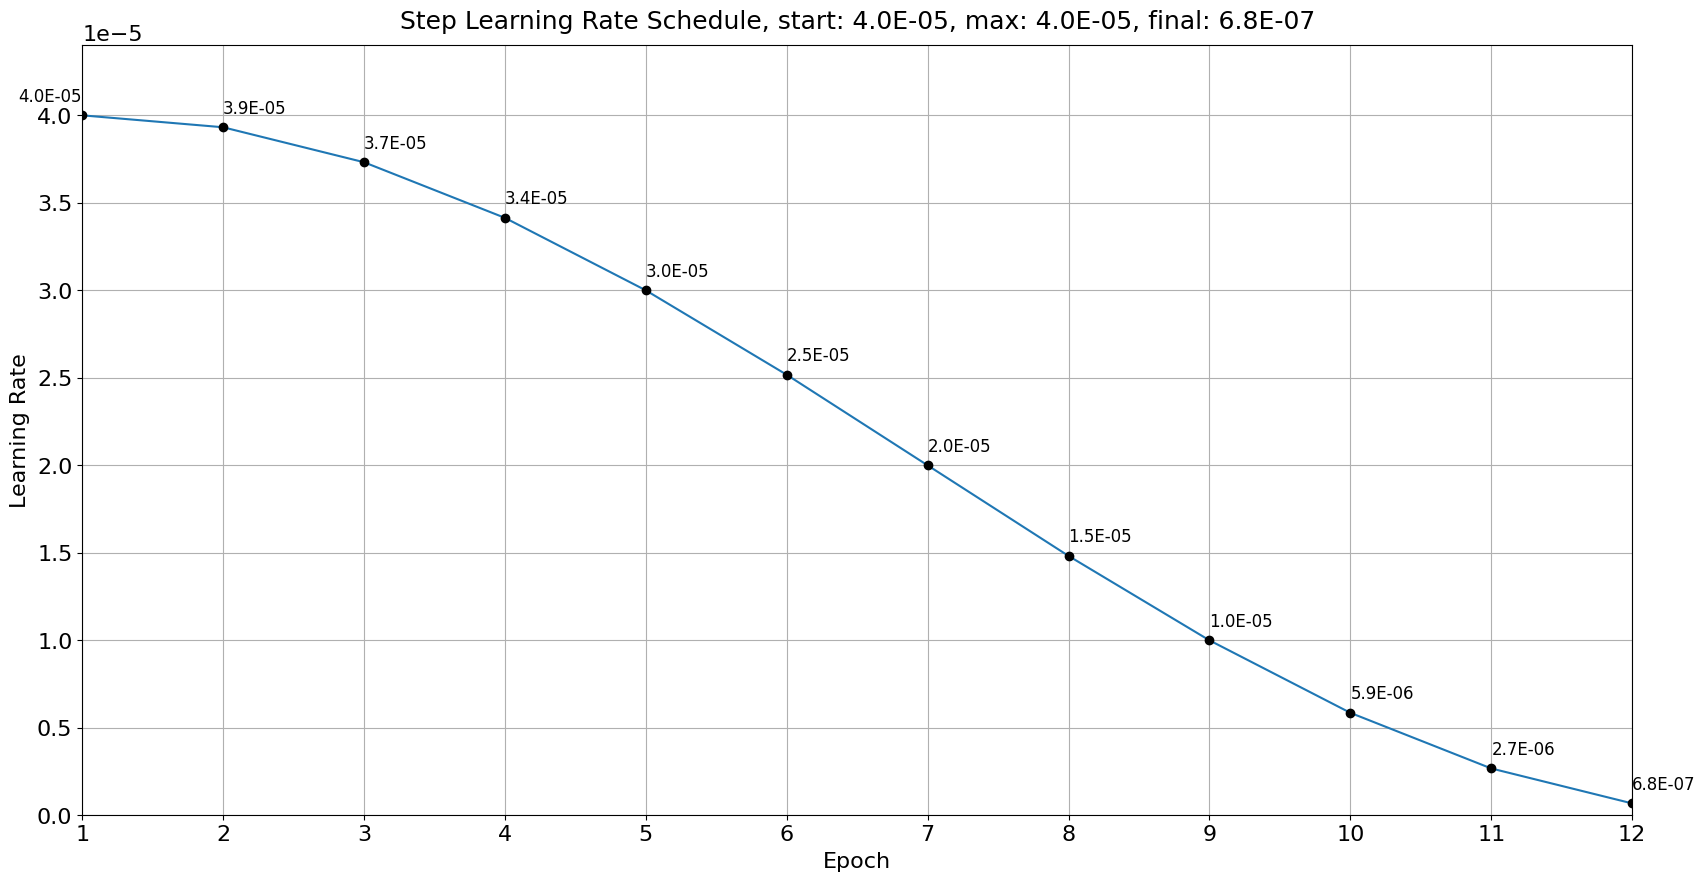

In [29]:
def normalize(image):
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image


# Plot the learning rate scheduler
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

    
# Learning rate scheduler with logaritmic warmup and cosine decay
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.10 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
    
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)



In [30]:
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [31]:
# Tensorflow Learning Rate Scheduler does not update weight decay, need to do it manually in a custom callback
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [32]:
def get_model():
    # Verify Mixed Policy Settings
    print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
    print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')
    
    with STRATEGY.scope():
        # Set seed for deterministic weights initialization
        seed_everything()
        
        # Inputs, note the names are equal to the dictionary keys in the dataset
        image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)
        
        # Normalize Input
        image_norm = normalize(image)
        

        # CNN Prediction in range [0,1]
        x = convnext.ConvNeXtV2Tiny(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            pretrained='imagenet21k-ft1k',
            num_classes=0,
        )(image_norm)
        
        # Average Pooling BxHxWxC -> BxC
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        


        # Dropout to prevent Overfitting
        x = tf.keras.layers.Dropout(0.30)(x)
        # Output value between [0, 1] using Sigmoid function
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        # We will use the famous AdamW optimizer for fast learning with weight decay
        optimizer = tfa.optimizers.AdamW(learning_rate=LR_MAX, weight_decay=LR_MAX*WD_RATIO, epsilon=1e-6)
        optimizer = tfa.optimizers.SWA(
                    optimizer,
                    start_averaging = 5,
                    average_period = 3,
                )
        # Loss
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        
        # Metrics
        metrics = [
            pF1(),
            tfa.metrics.F1Score(num_classes=1, threshold=0.50),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy(),
        ]

        model = tf.keras.models.Model(inputs=image, outputs=outputs)
        
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model

In [33]:
model = get_model()
# Plot model summary
model.summary()

Compute dtype: float32
Variable dtype: float32
115146752/115145456 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 1152, 1152, 1)]   0         
_________________________________________________________________
tf.repeat (TFOpLambda)       (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 1152, 1152, 3)     0         
_________________________________________________________

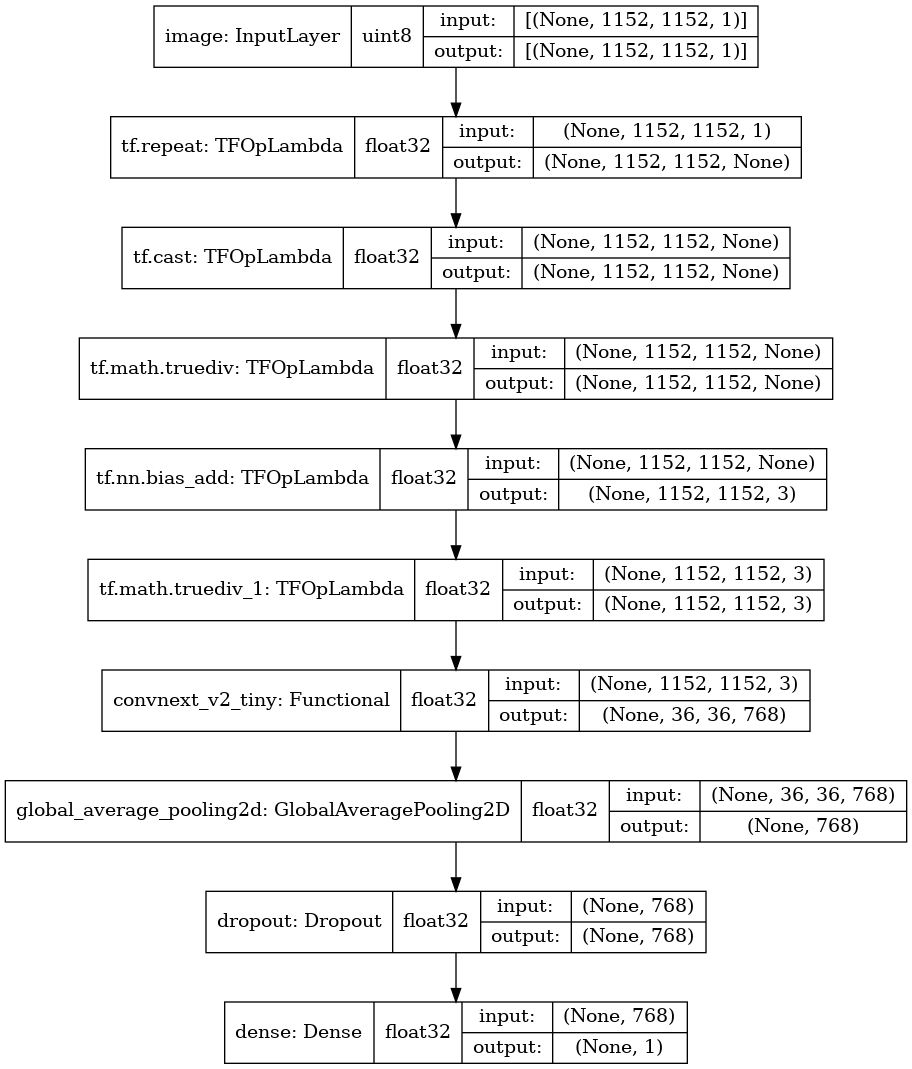

In [34]:
# Model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

In [35]:
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=f'best_{VERSION}.h5',
#     save_weights_only=True,
#     monitor='val_pF1',
#     mode='max',
#     save_best_only=True)


# history = model.fit_generator(datagenerator(batch_size=xxx),
#                                   steps_per_epoch=xxx, epochs=xxx, verbose=1, 
#                                   initial_epoch=initial_epoch,
#                                   callbacks=[checkpointer])


In [36]:
# Get true labels and predictions for validation set
y_true_val = []
y_pred_val = []

for fold, (TFRECORDS_TRAIN, TFRECORDS_VAL) in enumerate(enumsplit):    
    print(f'# TFRECORDS_TRAIN: {len(TFRECORDS_TRAIN)}, # TFRECORDS_VAL: {len(TFRECORDS_VAL)}')
    # Get Train/Validation datasets
    train_dataset = get_dataset(TFRECORDS_TRAIN, val=False, debug=False)
    val_dataset = get_dataset(TFRECORDS_VAL, val=True, debug=False)

    TRAIN_STEPS_PER_EPOCH = len(TFRECORDS_TRAIN) * N_SAMPLES_TFRECORDS // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = len(TFRECORDS_VAL) * N_SAMPLES_TFRECORDS // BATCH_SIZE
    print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}, VAL_STEPS_PER_EPOCH: {VAL_STEPS_PER_EPOCH}')

    # Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
    tf.keras.backend.clear_session()
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)

    model = get_model()
    
#     # Validation metric on initialized model
#     _ = model.evaluate(
#             get_dataset(TFRECORDS_VAL, val=True),
#             verbose=VERBOSE,
#             steps=VAL_STEPS_PER_EPOCH,
#         )
    
#     # Train Output Baseline
#     train_preds = model.predict(
#             get_dataset(TFRECORDS_TRAIN, val=True),
#             verbose=VERBOSE,
#             steps=128,
#         ).squeeze()
    save_dir = f'fold{fold}'
    try:
        os.mkdir(save_dir)
    except:
        1

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'model_{epoch:03d}.hdf5'),
                                       verbose=1, save_weights_only=True, period=1)
    # Train model on TPU!
    history = model.fit(
            train_dataset,
            steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
            validation_data = val_dataset,
            epochs = N_EPOCHS,
            verbose = VERBOSE,
            callbacks = [
                lr_callback,
                WeightDecayCallback(),
                model_checkpoint_callback
            ],
            class_weight = {
                0: 1.0,
                1: 3.0,
            },
        )
    
    model.save_weights(f'model_{fold}.h5')
    

    for X_batch, y_batch in tqdm(get_dataset(TFRECORDS_VAL, val=True), total=VAL_STEPS_PER_EPOCH):
        y_true_val += y_batch.numpy().tolist()
        y_pred_val += model.predict_on_batch(X_batch).squeeze().tolist()

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171
Compute dtype: float32
Variable dtype: float32
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Epoch 1/12
learning rate: 4.00e-05, weight decay: 4.00e-07
685/685 - 689s - loss: 0.4144 - pF1: 0.0776 - f1_score: 0.0197 - precision: 0.0871 - recall: 0.0111 - auc: 0.5882 - binary_accuracy: 0.9523 - val_loss: 0.1434 - val_pF1: 0.0378 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7014 - val_binary_accuracy: 0.9821

Epoch 00001: saving model to fold0/model_001.hdf5
Epoch 2/12
learning rate: 3.93e-05, weight decay: 3.93e-07
685/685 - 480s - loss: 0.3618 - pF1: 0.1188 - f1_score: 0.1428 - precision: 0.3043 - recall: 0.0933 - auc: 0.7037 - binary_accuracy: 0.9521 - val_loss: 0.2481 - val_pF1: 0.0763 - val_f1_score: 0.1937 - val_precision: 0.1268 - val_recall: 0.4103 - val_auc: 0.8235 - val_binary_accuracy: 0.9391

E

  0%|          | 0/171 [00:00<?, ?it/s]

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171
Compute dtype: float32
Variable dtype: float32
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Epoch 1/12
learning rate: 4.00e-05, weight decay: 4.00e-07
685/685 - 678s - loss: 0.4781 - pF1: 0.0596 - f1_score: 0.0121 - precision: 0.0281 - recall: 0.0077 - auc: 0.4951 - binary_accuracy: 0.9480 - val_loss: 0.1202 - val_pF1: 0.0321 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5512 - val_binary_accuracy: 0.9784

Epoch 00001: saving model to fold1/model_001.hdf5
Epoch 2/12
learning rate: 3.93e-05, weight decay: 3.93e-07
685/685 - 481s - loss: 0.4132 - pF1: 0.0630 - f1_score: 0.0091 - precision: 0.0523 - recall: 0.0050 - auc: 0.5242 - binary_accuracy: 0.9555 - val_loss: 0.1758 - val_pF1: 0.0382 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5660 - val_binary_accurac

  0%|          | 0/171 [00:00<?, ?it/s]

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171
Compute dtype: float32
Variable dtype: float32
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Epoch 1/12
learning rate: 4.00e-05, weight decay: 4.00e-07
685/685 - 680s - loss: 0.4073 - pF1: 0.0844 - f1_score: 0.0361 - precision: 0.1352 - recall: 0.0208 - auc: 0.6283 - binary_accuracy: 0.9537 - val_loss: 0.1280 - val_pF1: 0.0562 - val_f1_score: 0.0431 - val_precision: 1.0000 - val_recall: 0.0220 - val_auc: 0.7397 - val_binary_accuracy: 0.9797

Epoch 00001: saving model to fold2/model_001.hdf5
Epoch 2/12
learning rate: 3.93e-05, weight decay: 3.93e-07
685/685 - 482s - loss: 0.3133 - pF1: 0.1793 - f1_score: 0.2827 - precision: 0.3982 - recall: 0.2191 - auc: 0.7882 - binary_accuracy: 0.9536 - val_loss: 0.1314 - val_pF1: 0.1239 - val_f1_score: 0.3134 - val_precision: 0.3600 - val_recall: 0.2775 - val_auc: 0.8208 - val_binary_accuracy: 0.9748

Epoch 00002: 

  0%|          | 0/171 [00:00<?, ?it/s]

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171
Compute dtype: float32
Variable dtype: float32
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Epoch 1/12
learning rate: 4.00e-05, weight decay: 4.00e-07
685/685 - 682s - loss: 0.4152 - pF1: 0.0650 - f1_score: 0.0094 - precision: 0.0744 - recall: 0.0050 - auc: 0.5351 - binary_accuracy: 0.9565 - val_loss: 0.1385 - val_pF1: 0.0391 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6255 - val_binary_accuracy: 0.9782

Epoch 00001: saving model to fold3/model_001.hdf5
Epoch 2/12
learning rate: 3.93e-05, weight decay: 3.93e-07
685/685 - 480s - loss: 0.3941 - pF1: 0.0701 - f1_score: 0.0064 - precision: 0.0706 - recall: 0.0033 - auc: 0.5775 - binary_accuracy: 0.9574 - val_loss: 0.1762 - val_pF1: 0.0433 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6615 - val_binary_accurac

  0%|          | 0/171 [00:00<?, ?it/s]

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20
TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171
Compute dtype: float32
Variable dtype: float32
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Epoch 1/12
learning rate: 4.00e-05, weight decay: 4.00e-07
685/685 - 680s - loss: 0.3840 - pF1: 0.0766 - f1_score: 0.0334 - precision: 0.1480 - recall: 0.0188 - auc: 0.5974 - binary_accuracy: 0.9564 - val_loss: 0.2112 - val_pF1: 0.0623 - val_f1_score: 0.0915 - val_precision: 0.3111 - val_recall: 0.0536 - val_auc: 0.7076 - val_binary_accuracy: 0.9746

Epoch 00001: saving model to fold4/model_001.hdf5
Epoch 2/12
learning rate: 3.93e-05, weight decay: 3.93e-07
685/685 - 481s - loss: 0.3148 - pF1: 0.1582 - f1_score: 0.2543 - precision: 0.3852 - recall: 0.1897 - auc: 0.7729 - binary_accuracy: 0.9560 - val_loss: 0.1494 - val_pF1: 0.1516 - val_f1_score: 0.2583 - val_precision: 0.2079 - val_recall: 0.3410 - val_auc: 0.7954 - val_binary_accuracy: 0.9533

Epoch 00002: 

  0%|          | 0/171 [00:00<?, ?it/s]

In [37]:
len(y_true_val)

54705

In [38]:
len(y_pred_val)

54705

# F1 By Threshold

In [39]:
# # Get true labels and predictions for validation set
# y_true_val = []
# y_pred_val = []
# for X_batch, y_batch in tqdm(get_dataset(TFRECORDS_VAL, val=True), total=VAL_STEPS_PER_EPOCH):
#     y_true_val += y_batch.numpy().tolist()
#     y_pred_val += model.predict_on_batch(X_batch).squeeze().tolist()

In [40]:
# source: https://www.kaggle.com/code/sohier/probabilistic-f-score
# Competition Leaderboard Metric
def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

  0%|          | 0/101 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


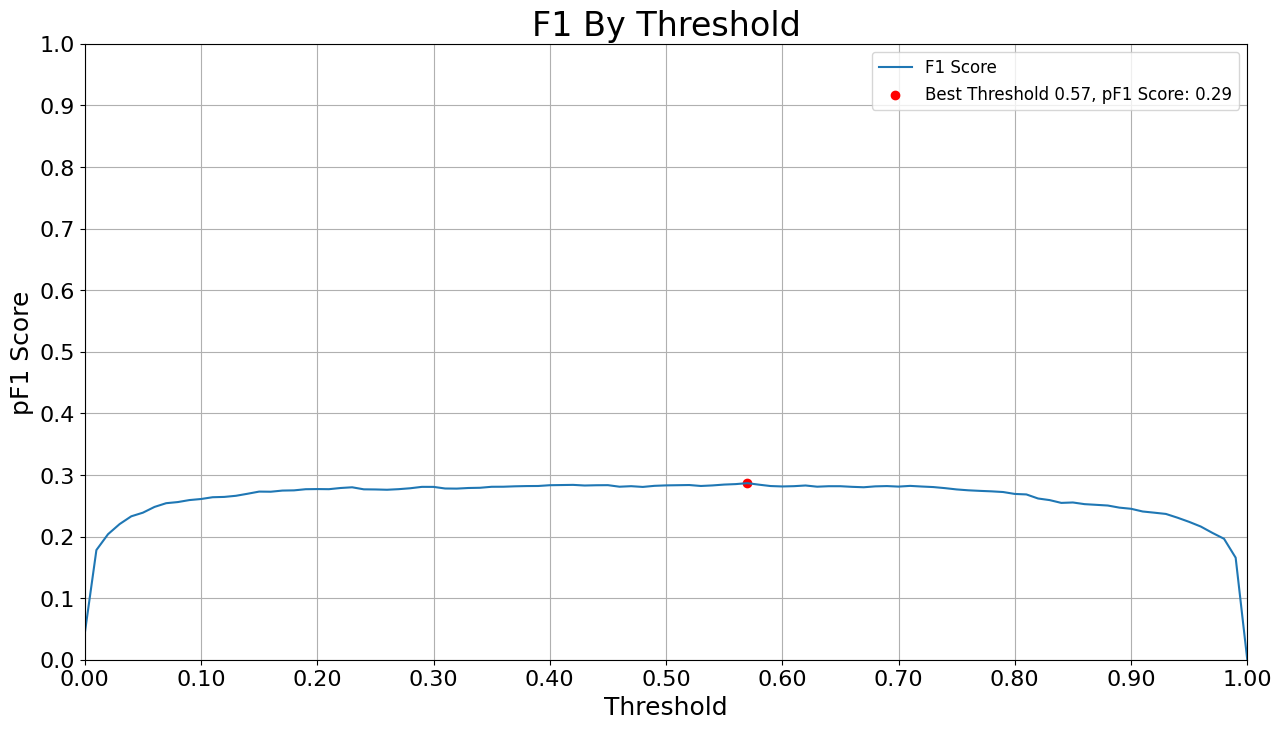

In [41]:
# Plot pF1 by threshold plot to find best threshold
pf1_by_threshold = []
thresholds = np.arange(0, 1.01, 0.01)
for t in tqdm(thresholds):
    # Compute pF1 for each threshold
    pf1_by_threshold.append(
        pfbeta(y_true_val, y_pred_val > t)
    )
    
plt.figure(figsize=(15,8))
plt.title('F1 By Threshold', size=24)
plt.plot(pf1_by_threshold, label='F1 Score')

# Best threshold and pF1 score
arg_max = np.argmax(pf1_by_threshold)
val_max = np.max(pf1_by_threshold)
threshold_best = thresholds[arg_max]
plt.scatter(arg_max, val_max, color='red', label=f'Best Threshold {threshold_best:.2f}, pF1 Score: {val_max:.2f}')

# Plot pF1 by Threshold
plt.xticks(np.arange(0, 110, 10), [f'{t:.2f}' for t in np.arange(0, 1.1, 0.1)])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Threshold')
plt.ylabel('pF1 Score')
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Training History

In [42]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

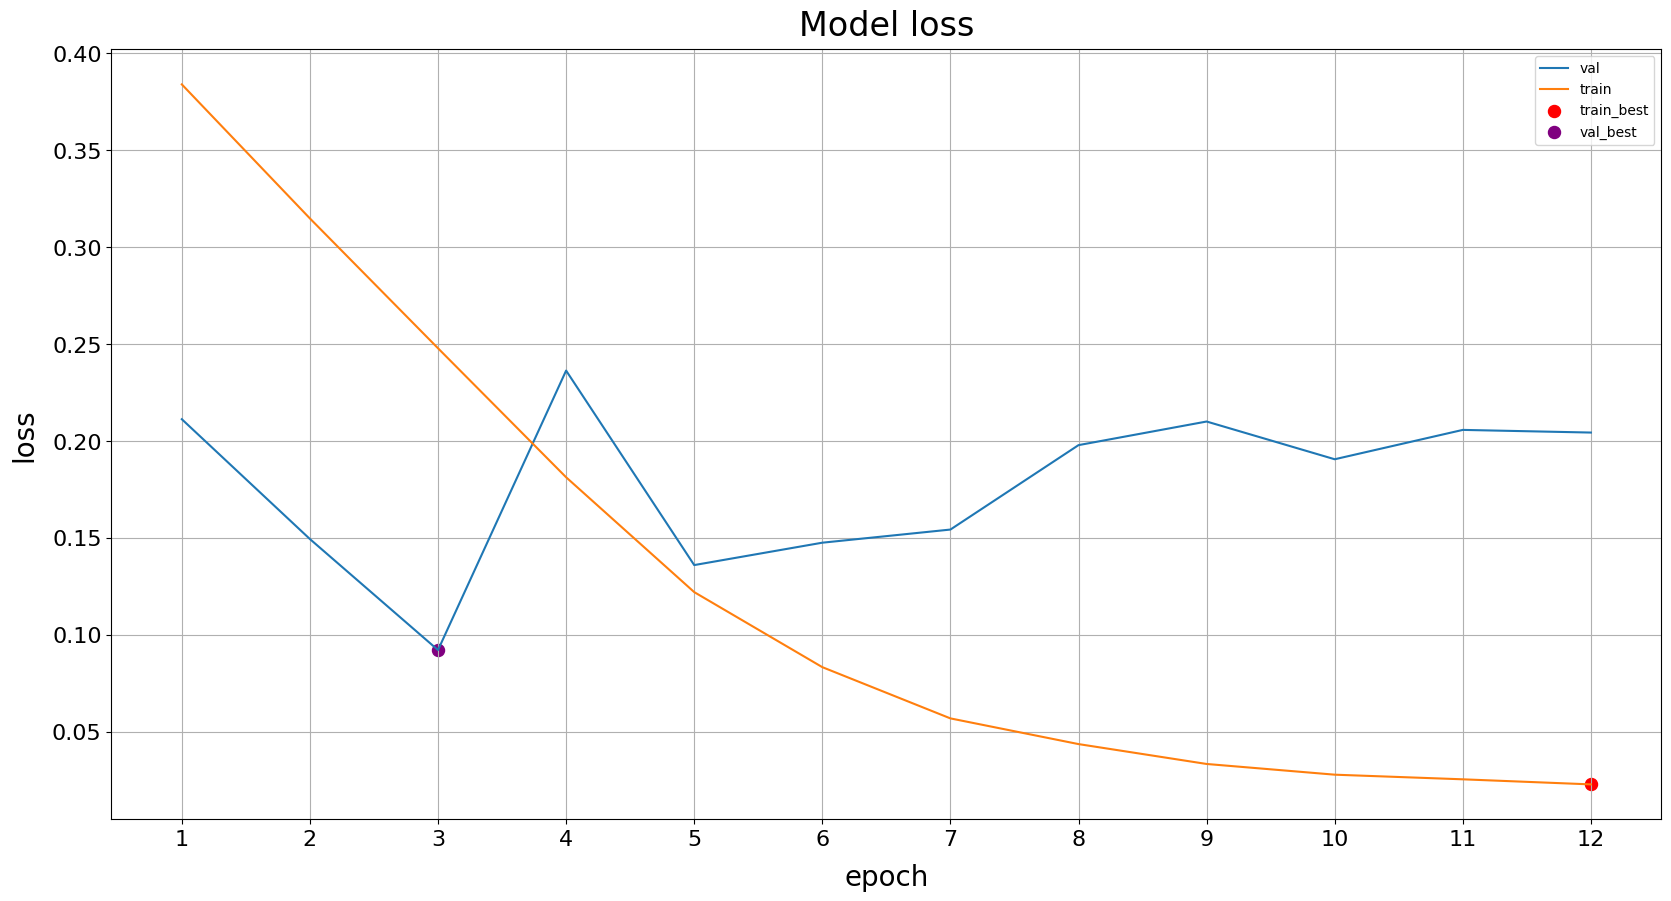

In [43]:
plot_history_metric('loss', f_best=np.argmin)

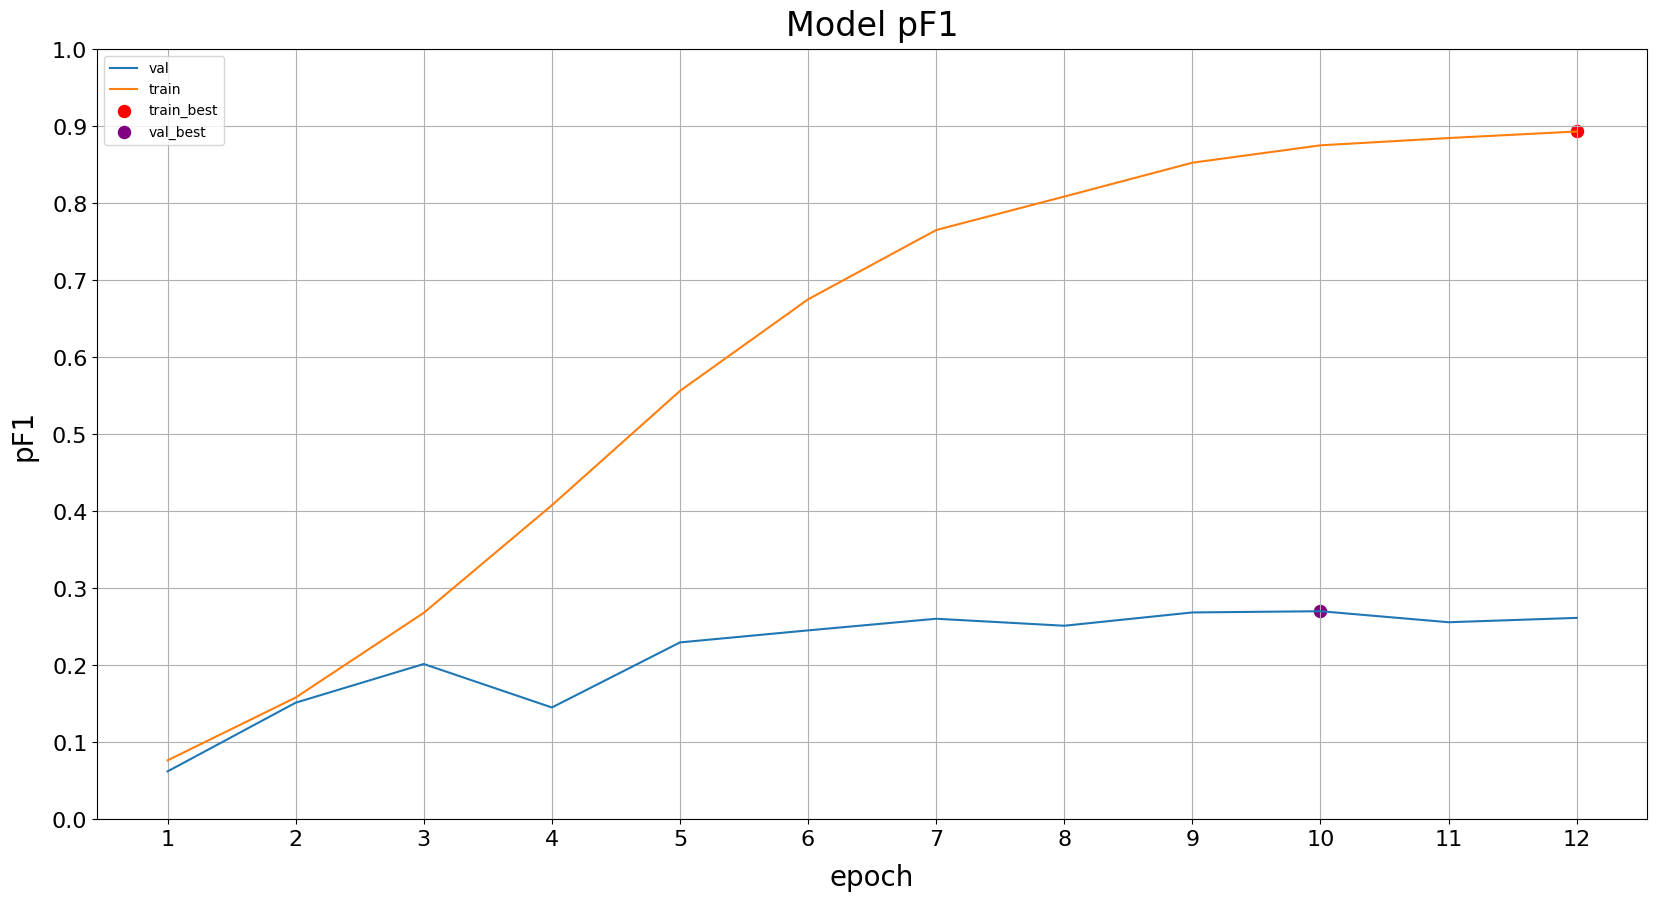

In [44]:
plot_history_metric('pF1', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

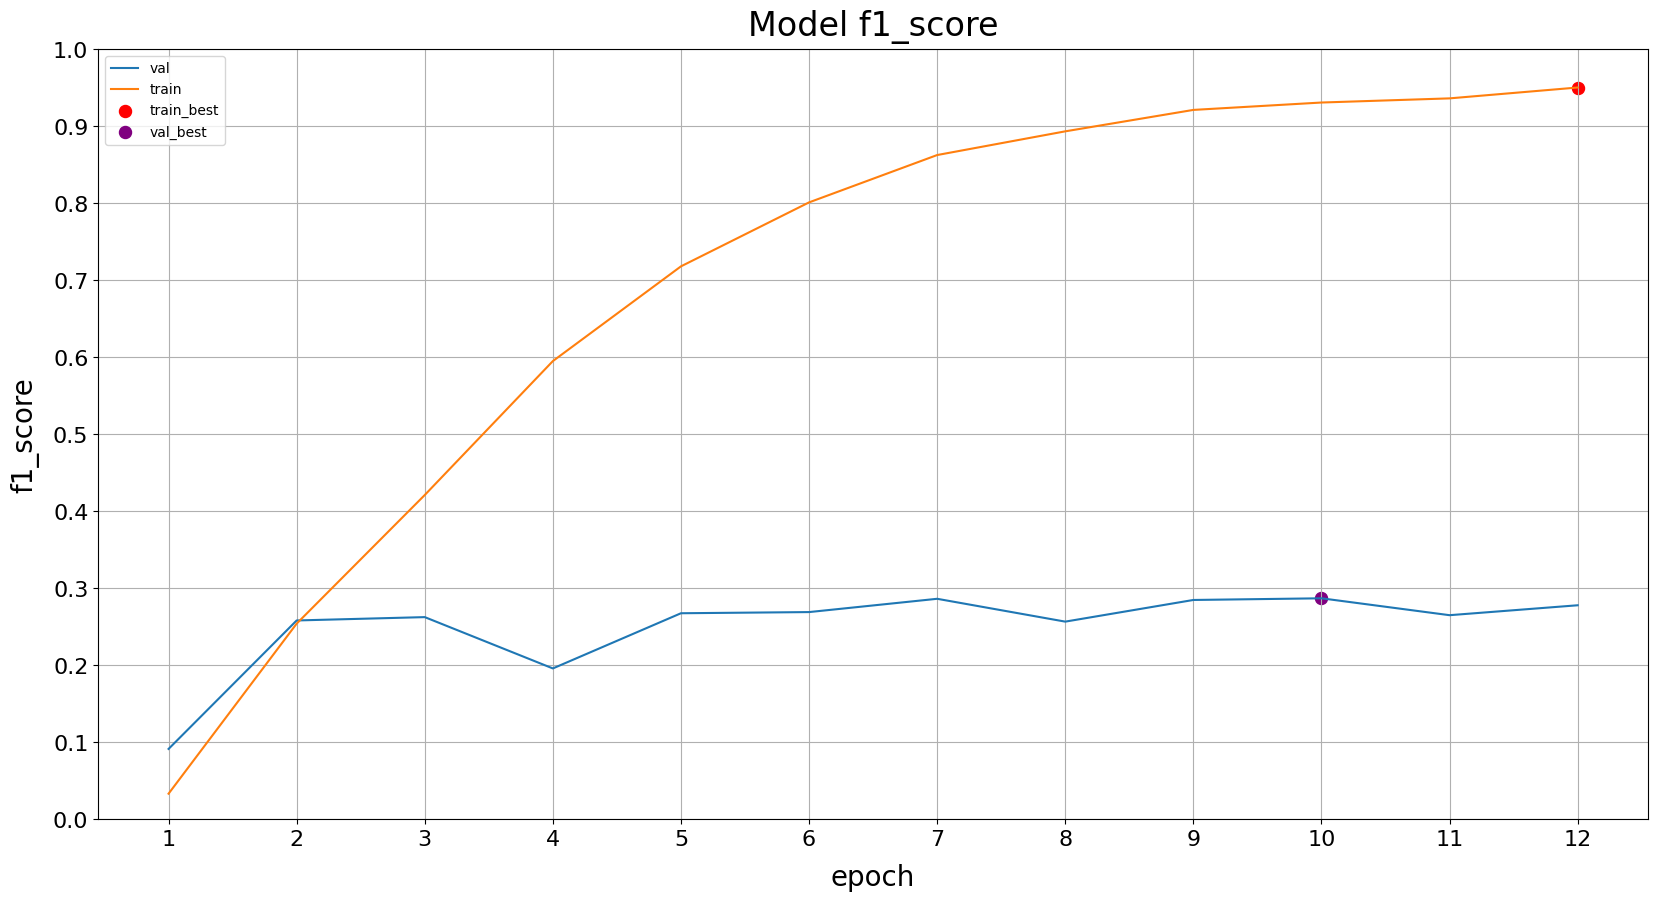

In [45]:
plot_history_metric('f1_score', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

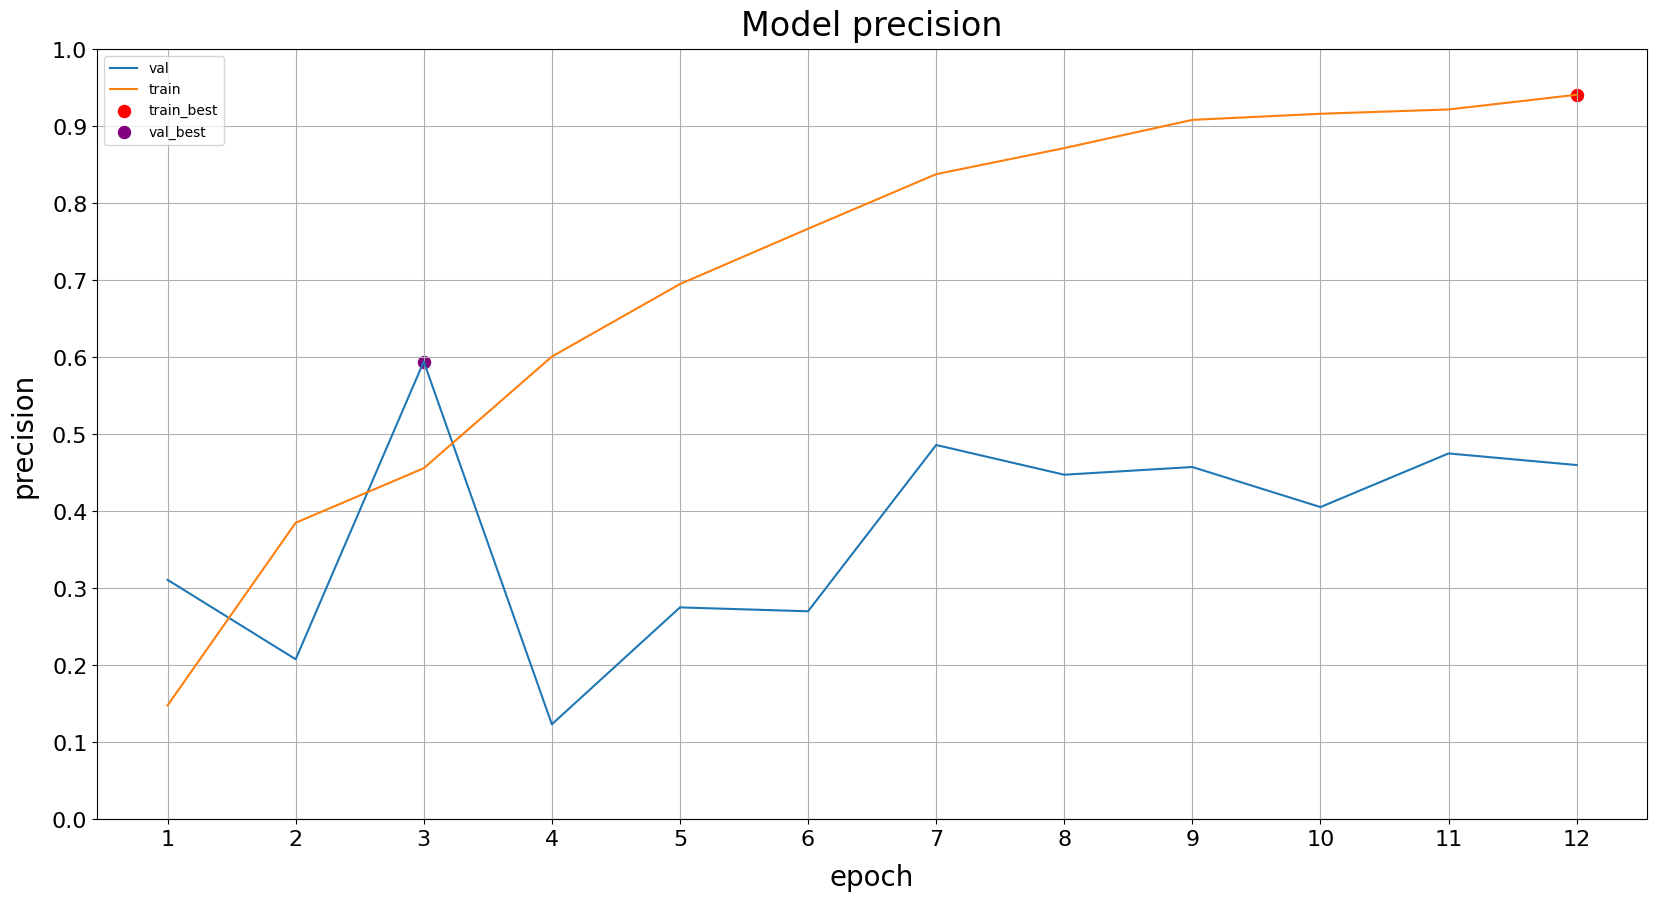

In [46]:
plot_history_metric('precision', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

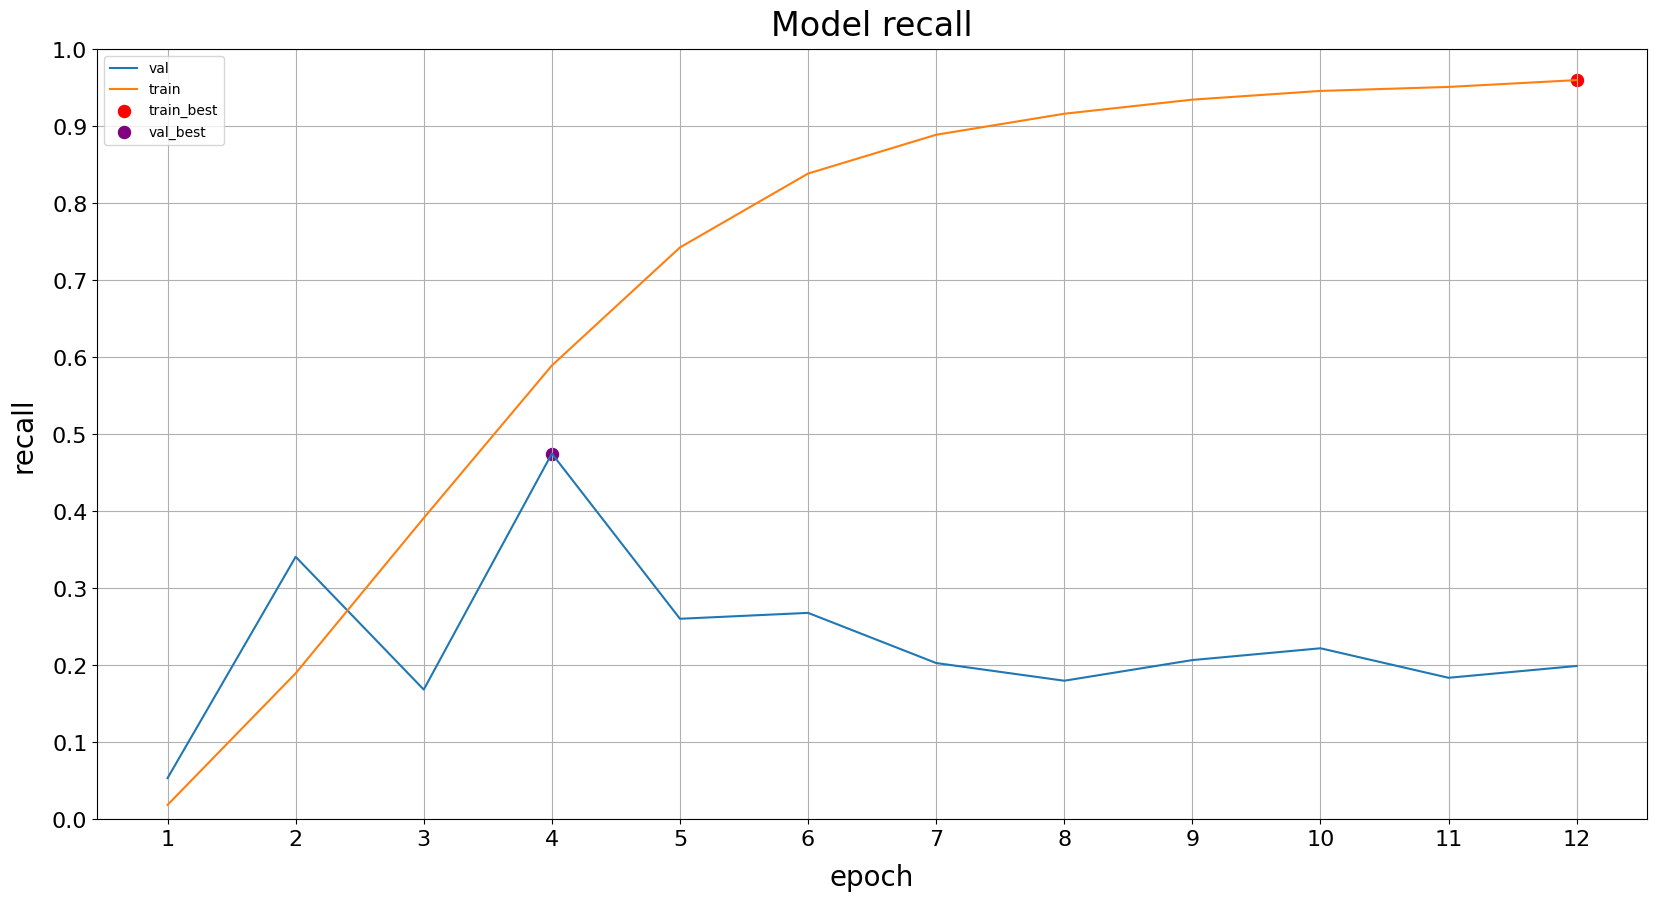

In [47]:
plot_history_metric('recall', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

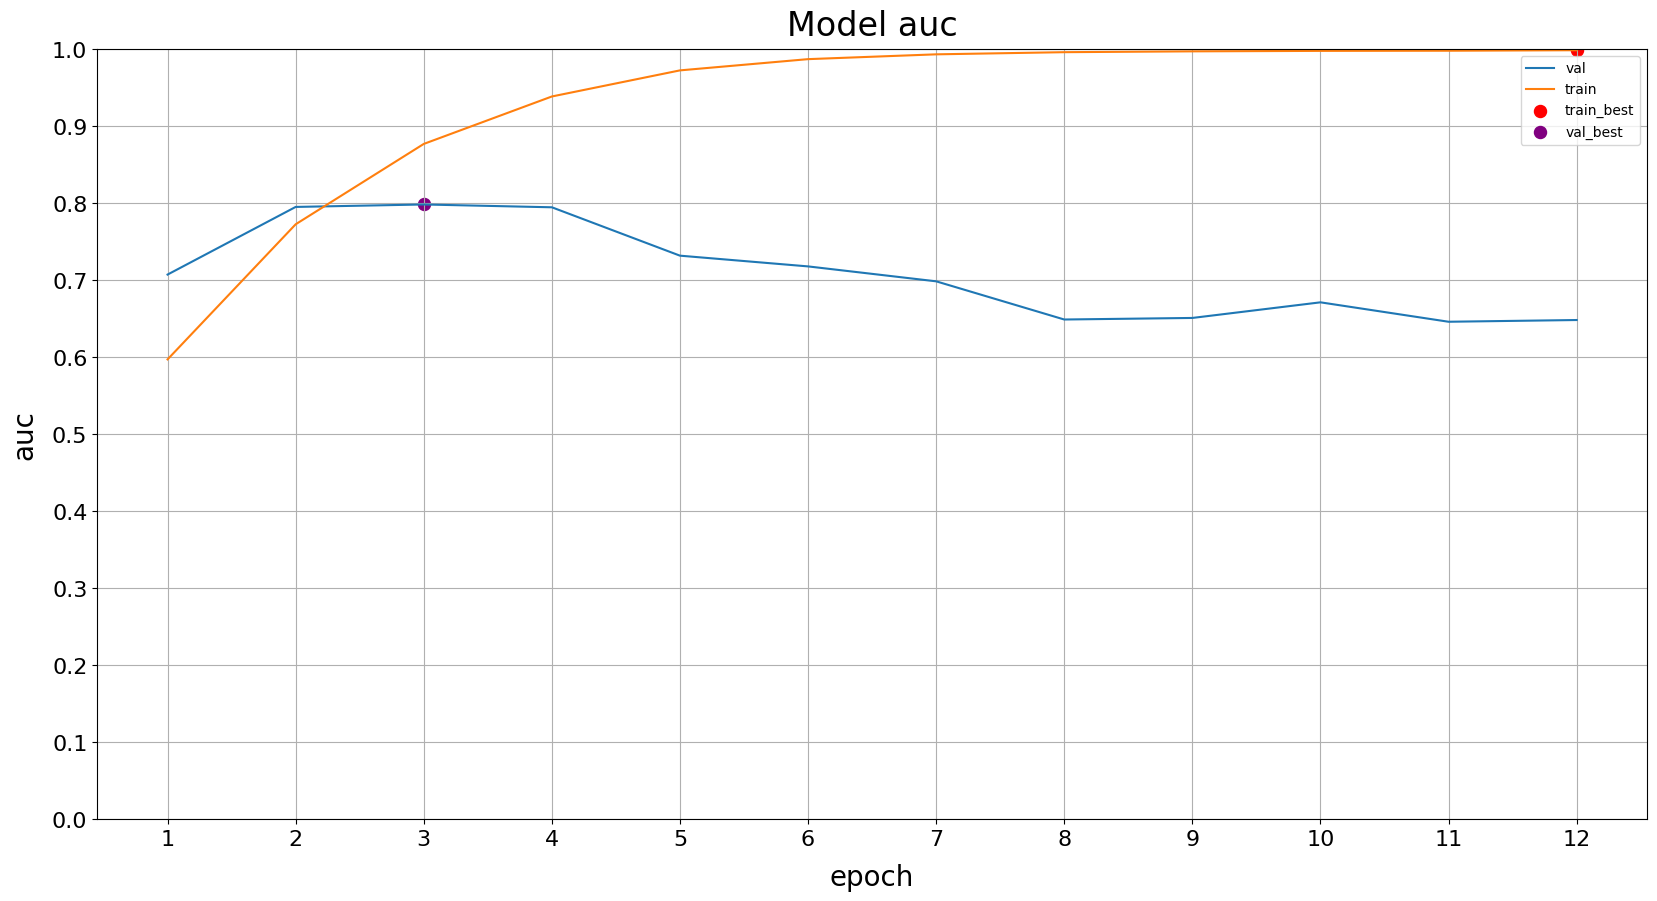

In [48]:
plot_history_metric('auc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

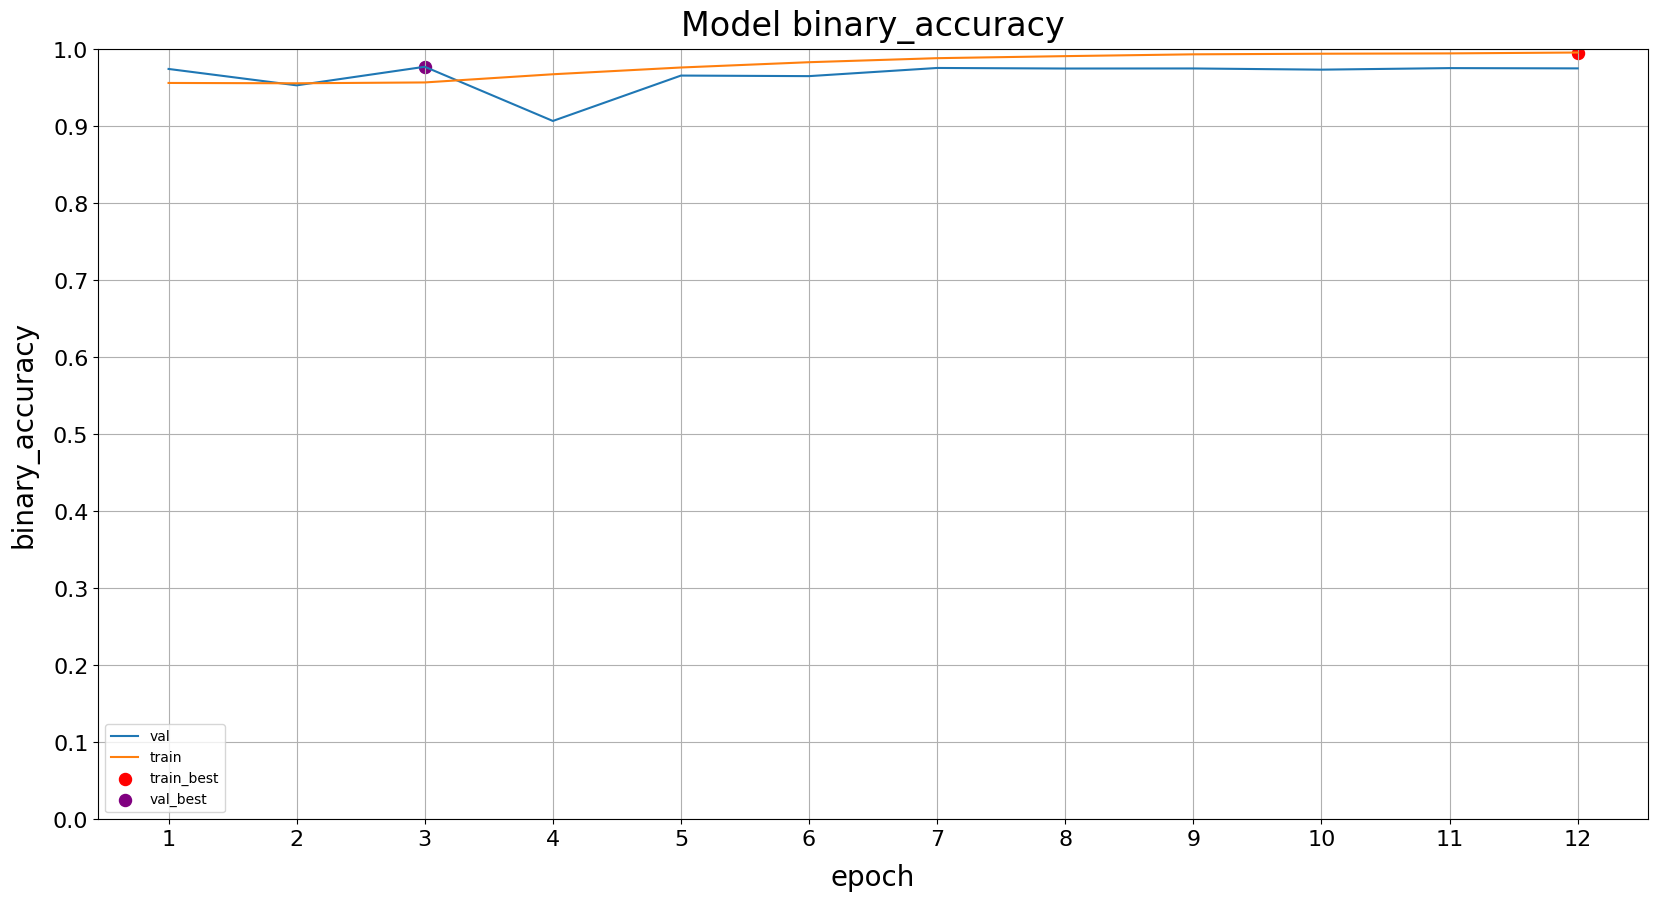

In [49]:
plot_history_metric('binary_accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))